<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/AutoencoderBasico_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nos descargamos las imágenes con un ancho de 256 de ancho. Vamos a ir escalando a 64, 128 y 256. Lo haremos con cv2.resize()

In [1]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-27 14:41:00 URL:https://uc692652b60e36df315c59ee3105.dl.dropboxusercontent.com/cd/0/inline2/BoCHd0WbQeAioV0-m9q1wmn740KteyQqhlsM4JtfB5jyqVZlSotfim4TjUfjJjgbehcWchxJeFp-awNDzKspJAC4LDKQWCh1lyE2GI-XbxwebS9z7GD3EHeXJBmXPgjVqhZRomKhMAbiPeoHUC0toZ-7gNyJJmTBV_SoEHvtWzQok-leD_e2N5IJYtHyBwwsjTcyypn5yWJhOr0DcQSuAsF4AqfDnLXX_x8Zt2ygqjyqSooXeBfMTCAkCFq23EaGAytDkTiFiB499XIl4aPScLPK2XLpphbcPIFhJhBroxbMnPC3WtVwBl2HcHgMoT0n7c7N74R-kH4ABgXVxpvC3cht4RANmDgv-HDJgZRZET9YkF2NT8bV0cVgDbnDLIlBeTExs21lS0waBZrAArqOlEvLKBCVsXwwiC4hG__6xofZjw/file [138777773/138777773] -> "train.zip" [1]
2022-06-27 14:41:05 URL:https://uc7ace56af4766f60266a816514f.dl.dropboxusercontent.com/cd/0/inline2/BoDgAP24qcQBr1c17tazZJtfbfkBHs-0wR7MhAglZGJHUeQf8JE9uFypIpn5KKXCjP8NUVorxD1mVS0hfzh-mMAosDN1pbh2SNLlOFwEkM8YnqtRkGX7Pnvp84iMz659XpmUEX4AFrstDT1Ye0JUhZTTXJFCM-EoPajWeuNlvd7apphi2PU4zi3kd7nhPpEwgrgEWj4cdqu7Lxzde601wEJc10t4-aQ8-mUnsvjeXg15aoV5yzYYpywm-ABwgQ_m6d5JV004i0xZn_JD7WLIg-J_l4os_2GMoQTMuNzir2lmfI3S3tTt0-fV0vfv26cQKIg

In [2]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

## Librerías

In [3]:
import PIL
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [4]:
trainPath = 'Training_Set_Pre/'
testPath  = 'Test_Set_Pre/'
valPath  =  'Evaluation_Set_Pre/'

In [5]:
df_train = pd.read_csv(trainPath + '/train.csv')
df_test = pd.read_csv(testPath + '/test.csv')
df_val = pd.read_csv(valPath + '/val.csv')

## Preparación de datos

### Crear Arrays

In [6]:
IMG_SIZE = 64

In [7]:
import shutil

def getNpArray(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    image = cv2.imread(pathO + '/' + str(id) + '.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [8]:
normalTrain, enfermedadTrain = getNpArray(df_train, trainPath + 'Training/')
normalTest, enfermedadTest = getNpArray(df_test, testPath + 'Test/')
normalVal, enfermedadVal = getNpArray(df_val, valPath + 'Validation/')

Normalizamos el dataset y lo preparamos para poder alimentar al autoencoder.

In [9]:
normalTrain = normalTrain.astype('float32') / 255.
enfermedadTrain = enfermedadTrain.astype('float32') / 255.

In [24]:
normalVal = normalVal.astype('float32') / 255.
enfermedadVal = enfermedadVal.astype('float32') / 255.

In [27]:
normalTest = normalTest.astype('float32') / 255.
enfermedadTest = enfermedadTest.astype('float32') / 255.

In [14]:
normalTest.shape

(134, 64, 64, 3)

Ya la tenemos reescalada a la medida deseada:

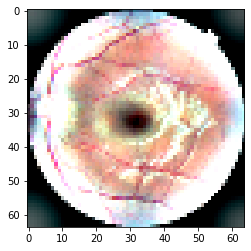

In [15]:
plt.imshow(normalTrain[0])

## Autoencoder

In [16]:
input_img = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))

### Encoder

In [17]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# Capa de max pooling con filtro de tamaño 2x2 y aplicando padding
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

### Decoder

In [18]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
 # Capa de upsampling con filtro de tamaño 2x2 y aplicando padding
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [19]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [20]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248  

### Entrenamiento

In [21]:
normalTrain.shape

(401, 64, 64, 3)

In [22]:
# trainTest = np.concatenate([normalTrain, normalTest, normalVal])

In [25]:
autoencoder.fit(normalTrain, normalTrain,
                epochs=50,
                batch_size=128,
                validation_data=(normalVal, normalVal))

Epoch 1/50
4/4 [==============================] - 0s 100ms/step - loss: 0.4754 - val_loss: 0.4930
Epoch 2/50
4/4 [==============================] - 0s 44ms/step - loss: 0.4753 - val_loss: 0.4903
Epoch 3/50
4/4 [==============================] - 0s 42ms/step - loss: 0.4741 - val_loss: 0.4911
Epoch 4/50
4/4 [==============================] - 0s 35ms/step - loss: 0.4738 - val_loss: 0.4924
Epoch 5/50
4/4 [==============================] - 0s 35ms/step - loss: 0.4743 - val_loss: 0.4896
Epoch 6/50
4/4 [==============================] - 0s 35ms/step - loss: 0.4741 - val_loss: 0.4925
Epoch 7/50
4/4 [==============================] - 0s 35ms/step - loss: 0.4741 - val_loss: 0.4896
Epoch 8/50
4/4 [==============================] - 0s 36ms/step - loss: 0.4726 - val_loss: 0.4889
Epoch 9/50
4/4 [==============================] - 0s 35ms/step - loss: 0.4720 - val_loss: 0.4894
Epoch 10/50
4/4 [==============================] - 0s 34ms/step - loss: 0.4719 - val_loss: 0.4891
Epoch 11/50
4/4 [===========

### Pruebas

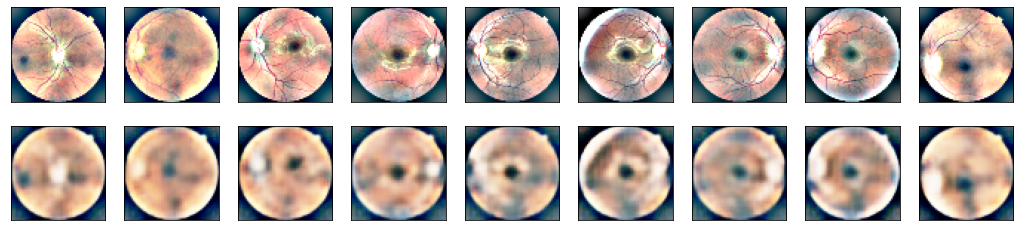

In [28]:
decoded_imgs = autoencoder.predict(normalTest)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(normalTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

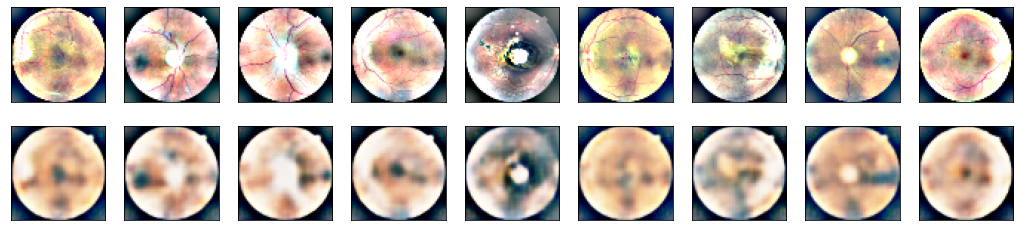

In [30]:
decoded_imgs = autoencoder.predict(enfermedadTest)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(enfermedadTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [41]:
from google.colab.patches import cv2_imshow

# make predictions on our image data and initialize our list of
# reconstruction errors

def test(autoencoder, data):
  decoded = autoencoder.predict(data)
  errors = []
  for (image, recon) in zip(data, decoded):
    mse = np.mean((image - recon) ** 2)
    errors.append(mse)
  thresh = np.quantile(errors, 0.999)
  idxs = np.where(np.array(errors) >= thresh)[0]
  return len(data)-len(idxs),len(idxs)

In [47]:
TN, FP = test(autoencoder, normalTest) #TN y FP

In [48]:
FN,TP = test(autoencoder, enfermedadTest) #FN y TP

Cálculo de las métricas

In [54]:
print("Accuracy:  ", ((TP + TN)/(TP + TN + FP + FN)))

recall = (TP/(TP + FN))
print("Recall :   ", recall)
precision = (TP/(TP + FP))
print("Precisión: ", precision)
print("F1-Score:  ", (2 * precision * recall)/(precision + recall))

Accuracy:   0.209375
Recall :    0.001976284584980237
Precisión:  0.5
F1-Score:   0.003937007874015748


[INFO] mse threshold: 0.014700450990349072
[INFO] 1 outliers found


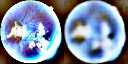

-1

In [38]:
from google.colab.patches import cv2_imshow

# make predictions on our image data and initialize our list of
# reconstruction errors
decoded = autoencoder.predict(enfermedadTest)
errors = []
# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(enfermedadTest, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.999)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))
# initialize the outputs array
outputs = None
# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = (enfermedadTest[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")
	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])
	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output
	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])
# show the output visualization
cv2_imshow(outputs)
cv2.waitKey(0)

## Diferente Arquitectura

https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726

In [ ]:
import numpy as np
from tensorflow import keras

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam

In [ ]:
autoencoder = Sequential()
autoencoder.add(Dense(3, activation='elu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(10,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(3,  activation='sigmoid'))
autoencoder.compile(loss='binary_crossentropy', optimizer = Adam())

In [ ]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64, 64, 3)         12        
                                                                 
 dense_1 (Dense)             (None, 64, 64, 64)        256       
                                                                 
 bottleneck (Dense)          (None, 64, 64, 10)        650       
                                                                 
 dense_2 (Dense)             (None, 64, 64, 64)        704       
                                                                 
 dense_3 (Dense)             (None, 64, 64, 128)       8320      
                                                                 
 dense_4 (Dense)             (None, 64, 64, 3)         387       
                                                                 
Total params: 10,329
Trainable params: 10,329
Non-traina

In [ ]:
trained_model = autoencoder.fit(
    normalTrain, normalTrain, 
    batch_size=1024, 
    epochs=50, 
    validation_data=(normalVal, normalVal))

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: -45.4375 - val_loss: -67.0534
Epoch 2/50
1/1 [==============================] - 5s 5s/step - loss: -66.7783 - val_loss: -89.6322
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: -89.4224 - val_loss: -113.6723
Epoch 4/50
1/1 [==============================] - 6s 6s/step - loss: -113.5447 - val_loss: -139.3624
Epoch 5/50
1/1 [==============================] - 5s 5s/step - loss: -139.3350 - val_loss: -166.8743
Epoch 6/50
1/1 [==============================] - 5s 5s/step - loss: -166.9681 - val_loss: -196.3662
Epoch 7/50
1/1 [==============================] - 5s 5s/step - loss: -196.6041 - val_loss: -228.0240
Epoch 8/50
1/1 [==============================] - 4s 4s/step - loss: -228.4303 - val_loss: -262.0197
Epoch 9/50
1/1 [==============================] - 5s 5s/step - loss: -262.6190 - val_loss: -298.5273
Epoch 10/50
1/1 [==============================] - 5s 5s/step - loss: -299.3434 - val_loss: -337

In [ ]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(normalTrain)  # bottleneck representation
decoded_output = autoencoder.predict(normalTrain)        # reconstruction
encoding_dim = 10

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

In [ ]:
predicts = autoencoder.predict(normalTest)

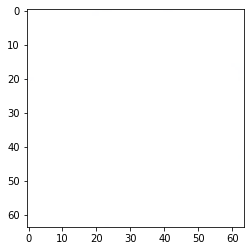

In [ ]:
plt.imshow(predicts[4])

## Otra arquitectura mas compleja

https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

In [ ]:
inputs = tf.keras.Input(shape=(64, 64, 3), name='input_layer')
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)
#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [ ]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 64, 64, 32)       128       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 64)        18496     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 32, 32, 64)       256       
 tion)                                                     

In [ ]:
hist=autoencoder.fit(normalTrain, normalTrain,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(normalVal, normalVal)
                )

Epoch 1/50
4/4 [==============================] - 8s 2s/step - loss: -57.3088 - val_loss: -114.2436
Epoch 2/50
4/4 [==============================] - 7s 2s/step - loss: -127.6965 - val_loss: -434.2847
Epoch 3/50
4/4 [==============================] - 7s 2s/step - loss: -191.8778 - val_loss: -1079.5952
Epoch 4/50
4/4 [==============================] - 7s 2s/step - loss: -249.6039 - val_loss: -1818.2222
Epoch 5/50
4/4 [==============================] - 7s 2s/step - loss: -302.6567 - val_loss: -2362.8333
Epoch 6/50
4/4 [==============================] - 7s 2s/step - loss: -352.9436 - val_loss: -2724.7598
Epoch 7/50
4/4 [==============================] - 7s 2s/step - loss: -402.6617 - val_loss: -3069.5925
Epoch 8/50
4/4 [==============================] - 7s 2s/step - loss: -452.1633 - val_loss: -3444.0637
Epoch 9/50
4/4 [==============================] - 7s 2s/step - loss: -502.4941 - val_loss: -3675.4141
Epoch 10/50
4/4 [==============================] - 7s 2s/step - loss: -553.3693 - val

In [ ]:
predicts = autoencoder.predict(normalTest)

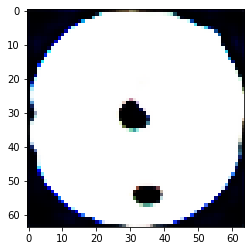

In [ ]:
plt.imshow(predicts[21])

In [ ]:
predicts = autoencoder.predict(enfermedadTest)

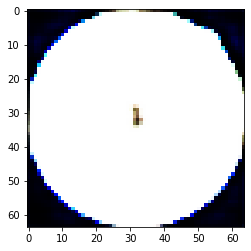

In [ ]:
plt.imshow(predicts[21])

## Otra alternativa

In [ ]:
normalTrain.shape[3]

3

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(normalTrain.shape[1], normalTrain.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=64, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()

In [ ]:
model.fit(
    normalTrain,
    normalTrain,
    epochs=50,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50


ValueError: ignored